In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pathlib import Path
import IPython

In [5]:
DATA_DIR = Path('data')

In [6]:
samples_directories = [ directory for directory in DATA_DIR.iterdir() if directory.is_dir() ]
print("number of valid samples: ", len(samples_directories))

number of valid samples:  10


In [7]:
SR = 18750
HOP_LEN = 64

In [8]:
filesname = [ directory / "Ch1Dat" for directory in samples_directories ]
signals = [ np.fromfile(str(filename), dtype='float32') for filename in filesname ]

In [9]:
idx = 0

In [10]:
S = np.abs(librosa.core.stft(signals[idx], n_fft=512, hop_length=HOP_LEN))
Sdb = librosa.amplitude_to_db(S, ref=1.0)

## Onset Detection

In [14]:
# Function that input a numpy and only remain positive value
def half_wave_rectifier(x):
    return (x + np.abs(x))/2

In [15]:
# Sum the positive change in each frequency bin
spectral_flux = np.mean(half_wave_rectifier(np.diff(Sdb, axis=1)), axis=0)

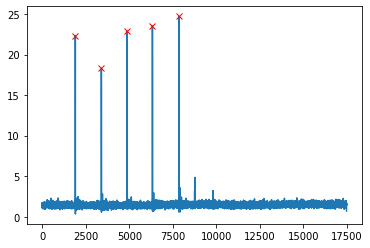

In [18]:
from scipy.signal import find_peaks

plt.plot(spectral_flux)
on_sets, _ = find_peaks(spectral_flux, height=10)
plt.plot(on_sets, spectral_flux[on_sets], 'rx')

In [19]:
on_sets_time = librosa.frames_to_time(on_sets, sr=SR, hop_length=HOP_LEN)
print(on_sets_time)

[ 6.49557333 11.59850667 16.62293333 21.60298667 26.77077333]


In [20]:
def draw_line_dots(x, y=2000):
    plt.hlines(y, 0, SR, color='w', linestyles='-')
    plt.plot(x, [y] * len(x), 'wx', markersize=7)

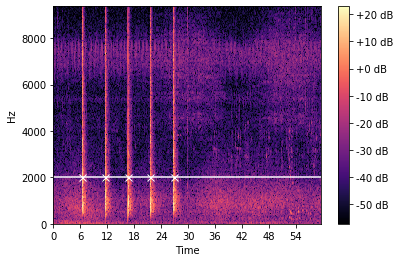

In [21]:
librosa.display.specshow(Sdb, y_axis='linear', x_axis='time', sr=SR, hop_length=HOP_LEN)
plt.colorbar(format='%+2.0f dB')
draw_line_dots(on_sets_time)
plt.show()

## Offset Detection

In [14]:
time_db = np.mean(Sdb, axis=0)

Text(0, 0.5, 'DB')

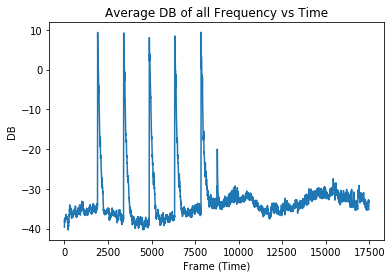

In [15]:
plt.title("Average DB of all Frequency vs Time")
plt.plot(time_db)
plt.xlabel("Frame (Time)")
plt.ylabel("DB")

In [16]:
#  Get the on set's DB and 
#  the off set will be the first encounter  DB that is equal of small than it.
off_sets = []

for on_set in on_sets:
    base_db = time_db[on_set]
    for frame in range(on_set+1, len(time_db), 1):
        if(time_db[frame] <= base_db):
            off_sets.append(frame)
            break

off_sets = np.array(off_sets)

In [17]:
off_sets_time = librosa.frames_to_time(off_sets, sr=SR, hop_length=HOP_LEN)
print(off_sets_time)

[ 7.61856    12.62933333 17.95413333 22.33002667 27.52512   ]


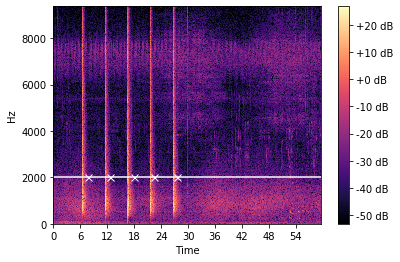

In [18]:
librosa.display.specshow(Sdb, y_axis='linear', x_axis='time', sr=SR, hop_length=HOP_LEN)
plt.colorbar(format='%+2.0f dB')
draw_line_dots(off_sets_time)
plt.show()

## Results

In [19]:
list(zip(on_sets_time, off_sets_time))

[(6.48192, 7.61856),
 (11.588266666666666, 12.629333333333333),
 (16.60928, 17.954133333333335),
 (21.592746666666667, 22.330026666666665),
 (26.760533333333335, 27.52512)]

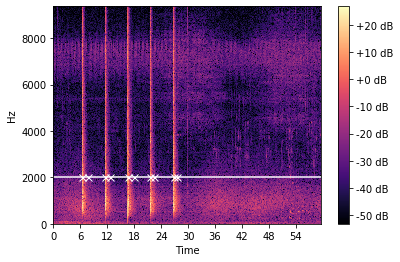

In [20]:
librosa.display.specshow(Sdb, y_axis='linear', x_axis='time', sr=SR, hop_length=HOP_LEN)
plt.colorbar(format='%+2.0f dB')
draw_line_dots(list(zip(on_sets_time, off_sets_time)))

C:\Users\jason\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\jason\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


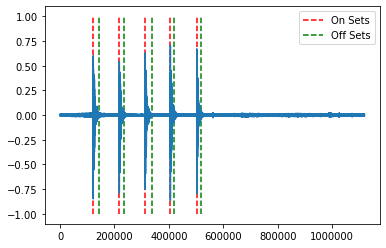

In [21]:
plt.plot(signals[idx])
plt.vlines(on_sets * HOP_LEN, -1, 1, color='r', linestyles='--', label="On Sets")
plt.vlines(off_sets * HOP_LEN, -1, 1, color='g', linestyles='--', label="Off Sets")
plt.legend()

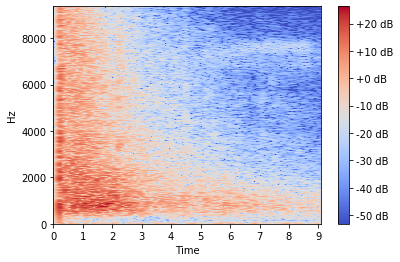

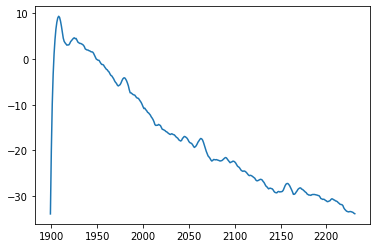

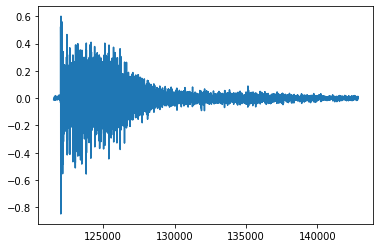

--------------------------------------------------


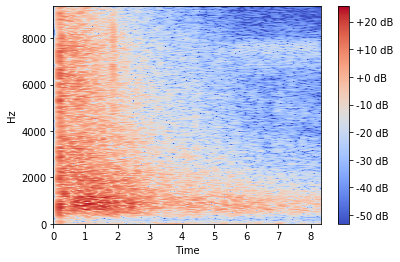

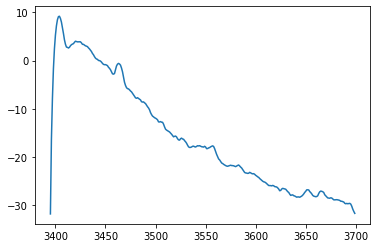

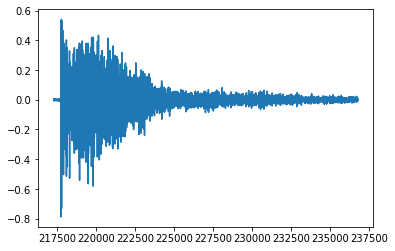

--------------------------------------------------


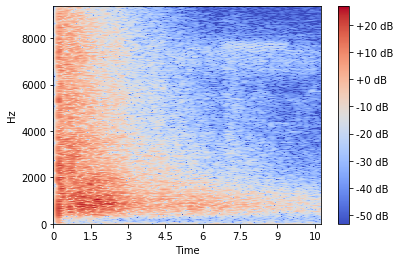

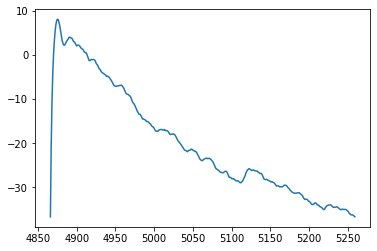

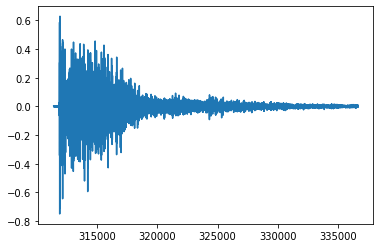

--------------------------------------------------


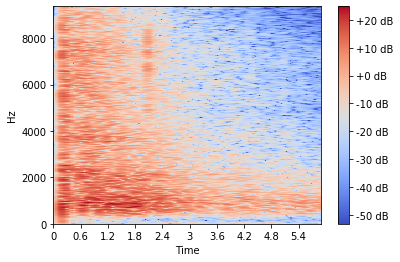

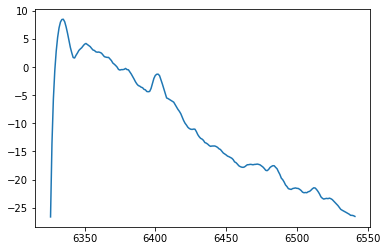

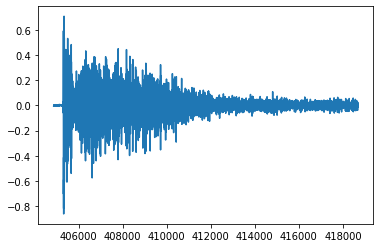

--------------------------------------------------


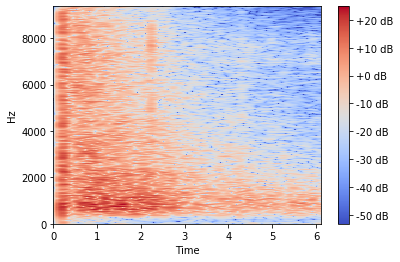

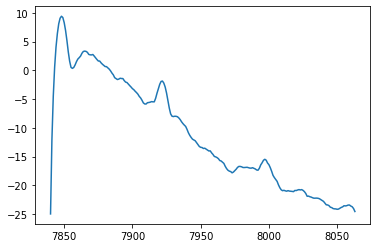

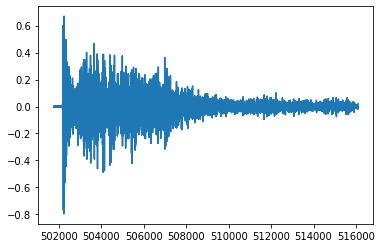

--------------------------------------------------


In [22]:
for (on_set, off_set) in zip(on_sets, off_sets):
    librosa.display.specshow(Sdb[:, on_set:off_set], y_axis='linear', x_axis='time', sr=SR)
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    plt.plot(range(on_set, off_set, 1), time_db[on_set:off_set])
    plt.show()
    plt.plot(range(on_set*HOP_LEN, off_set*HOP_LEN, 1), signals[idx][on_set*HOP_LEN:off_set*HOP_LEN])
    plt.show()
    IPython.display.display(IPython.display.Audio(signals[idx][on_set*HOP_LEN:off_set*HOP_LEN], rate=SR))
    print('-' * 50)

In [23]:
# Save the results
import csv

with open('{}.csv'.format(str(samples_directories[idx])), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ')
    for (on_set_time, off_set_time) in zip(on_sets_time, off_sets_time):
        writer.writerow([on_set_time, off_set_time])